## Configurando o Ambiente de Análise

In [1]:
from IPython.display import display, Markdown
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option("display.max_colwidth", None)
sns.set_theme(style="ticks", context="notebook", font_scale=1.2)
plt.rcParams.update({
    "figure.figsize": (12,6), 
    "axes.spines.top": False, 
    "axes.spines.right": False
})

## Carregando os Dados

In [2]:
def get_db_data(query):
    """
    Conecta ao banco usando psycopg2 e retorna um DataFrame.
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host='dw',
            database='dw',
            user='dba',
            password='root',
            port=5432
        )
        
        with conn.cursor() as cur:
            cur.execute(query)
            columns = [desc[0] for desc in cur.description]
            data = cur.fetchall()
            
        df = pd.DataFrame(data, columns=columns)
        return df
        
    except Exception as e:
        print(f"Erro ao conectar ao banco: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()

# Query para carregar a tabela silver
# Limita a quantidade de tuplas retornadas para evitar erros
# query = "SELECT * FROM silver.silver_flights"
query = "SELECT * FROM silver.silver_flights LIMIT 1000000"
silver_df = get_db_data(query)

# --- INÍCIO DO BLOCO DE CONVERSÃO DE DATAS ---
date_cols = [
    'scheduled_departure', 'departure_time', 
    'scheduled_arrival', 'arrival_time', 
    'wheels_off', 'wheels_on'
]

# Itera sobre as colunas e converte para datetime
# errors='coerce' garante que, se houver algum lixo, ele vira NaT sem travar o código
for col in date_cols:
    if col in silver_df.columns:
        silver_df[col] = pd.to_datetime(silver_df[col], errors='coerce')
        
print("Conversão de datas aplicada com sucesso.")
# --- FIM DO BLOCO DE CONVERSÃO DE DATAS ---

# Otimização para reduzir uso de memória (essencial para 5M de linhas)
for col in silver_df.select_dtypes(include=['object']).columns:
    num_unique_values = len(silver_df[col].unique())
    num_total_values = len(silver_df[col])
    # Se tivermos menos de 50% de valores únicos, converte para categoria
    if num_unique_values / num_total_values < 0.5:
        silver_df[col] = silver_df[col].astype('category')

# Downcast de floats (de 64bit para 32bit - economiza 50% de memória nos números)
for col in silver_df.select_dtypes(include=['float64']).columns:
    silver_df[col] = pd.to_numeric(silver_df[col], downcast='float')

print(f"Dados da camada Silver carregados com: {len(silver_df):,} tuplas × {silver_df.shape[1]} colunas")


Conversão de datas aplicada com sucesso.
Dados da camada Silver carregados com: 1,000,000 tuplas × 42 colunas


## Introdução

Este notebook apresenta a Análise Exploratória de Dados (EDA) sobre o conjunto de dados de voos nos Estados Unidos, disponibilizado pelo U.S. Department of Transportation. O objetivo é identificar padrões e inconsistências na qualidade dos dados (camada silver).

A análise é conduzida sob a ótica da Engenharia de Dados, e tem como principal finalidade:

- Diagnosticar a qualidade dos dados na camada silver;
- Identificar padrões e anomalias que possam impactar os relatórios de desempenho de voos.


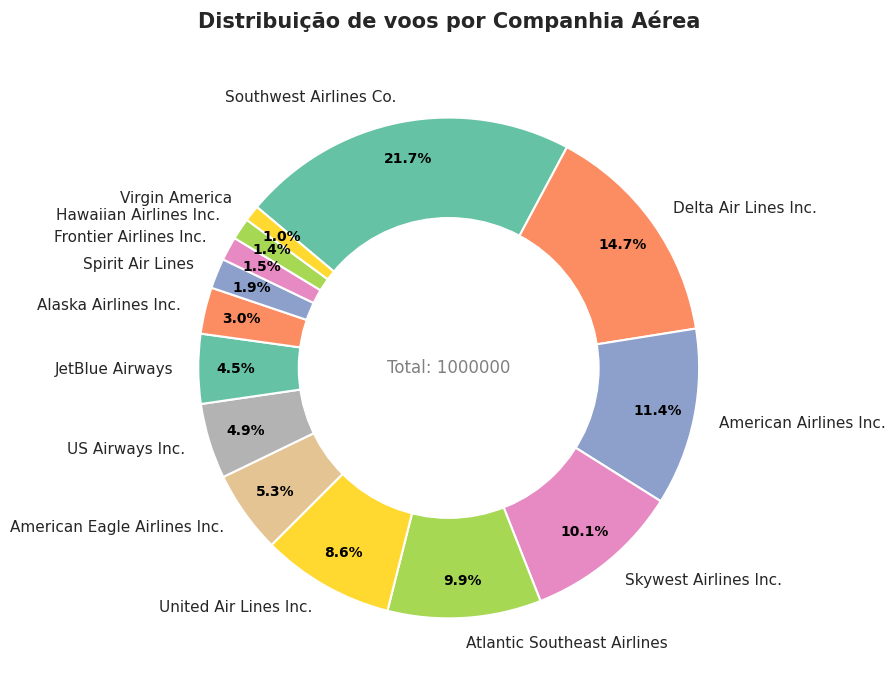

In [3]:
# Distribuição de voos por companhia aérea
flight_counts = silver_df['airline_name'].value_counts().sort_values(ascending=False)

# Paleta e explosão para destaque visual
colors = sns.color_palette("Set2", n_colors=len(flight_counts))
explode = [0.05 if i == 0 else 0.02 for i in range(len(flight_counts))]

fig, ax = plt.subplots(figsize=(9, 9))

wedges, texts, autotexts = ax.pie(
    flight_counts,
    labels=flight_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# Adiciona círculo central para efeito "donut"
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig.gca().add_artist(centre_circle)

# Ajustes visuais
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=11)
plt.title("Distribuição de voos por Companhia Aérea", fontsize=15, pad=20, weight="bold")
ax.text(0, 0, f"Total: {flight_counts.sum()}", ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

## Objetivos

1. **Explorar a estrutura dos dados validados**: tipos, volume, duplicatas e ausências;
2. **Avaliar a consistência interna**: duplicatas naturais, cardinalidade e formatos irregulares;
3. **Diagnosticar potenciais problemas de schema**: tipos incorretos e valores inconsistentes;

## Metodologia

A análise foi estruturada segundo um **fluxo incremental**, seguindo as seguintes etapas:

1. **Inspeção inicial**: Estrutura, dimensões e tipos de dados;
2. **Análise de valores ausentes**: Identificação e quantificação de nulos;
3. **Cardinalidade e duplicatas**: Diagnóstico de unicidade e granularidade;
4. **Verificação de tipos e inconsistências**: Identificação de colunas com tipos inadequados;


## Análise do Dataset de Voos (flights.csv)

### Inspeção inicial

In [4]:
print("Dimensões (linhas, colunas):", silver_df.shape)

Dimensões (linhas, colunas): (1000000, 42)


In [5]:
display(silver_df.head())

,flight_id,flight_year,flight_month,flight_day,flight_day_of_week,flight_date,airline_iata_code,airline_name,flight_number,tail_number,...,air_time,elapsed_time,scheduled_time,distance,is_overnight_flight,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2614879,2015,6,19,5,2015-06-19,DL,Delta Air Lines Inc.,1695,N911DE,...,69.0,85.0,99.0,447.0,False,0.0,0.0,0.0,0.0,0.0
1,2614880,2015,6,19,5,2015-06-19,DL,Delta Air Lines Inc.,1696,N324US,...,180.0,205.0,210.0,1481.0,False,0.0,0.0,0.0,0.0,0.0
2,2614881,2015,6,19,5,2015-06-19,DL,Delta Air Lines Inc.,1697,N959DL,...,76.0,108.0,106.0,534.0,False,0.0,0.0,0.0,0.0,0.0
3,2614882,2015,6,19,5,2015-06-19,DL,Delta Air Lines Inc.,1698,N812DN,...,228.0,251.0,273.0,2079.0,False,0.0,0.0,0.0,0.0,0.0
4,2614883,2015,6,19,5,2015-06-19,DL,Delta Air Lines Inc.,1699,N328NB,...,50.0,70.0,78.0,287.0,False,0.0,0.0,0.0,0.0,0.0


In [6]:
silver_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 42 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   flight_id                 1000000 non-null  int64         
 1   flight_year               1000000 non-null  int64         
 2   flight_month              1000000 non-null  int64         
 3   flight_day                1000000 non-null  int64         
 4   flight_day_of_week        1000000 non-null  int64         
 5   flight_date               1000000 non-null  category      
 6   airline_iata_code         1000000 non-null  category      
 7   airline_name              1000000 non-null  category      
 8   flight_number             1000000 non-null  int64         
 9   tail_number               1000000 non-null  category      
 10  origin_airport_iata_code  1000000 non-null  category      
 11  origin_airport_name       1000000 non-null  categor

In [7]:
display(silver_df.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
flight_id,1000000.0,NaN,NaN,NaN,1584231.750025,5171.0,255174.75,2624119.5,2874126.25,3150235.0,1317193.272244
flight_year,1000000.0,NaN,NaN,NaN,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,0.0
flight_month,1000000.0,NaN,NaN,NaN,3.90418,1.0,1.0,6.0,7.0,7.0,2.797818
flight_day,1000000.0,NaN,NaN,NaN,15.274832,1.0,7.0,15.0,23.0,31.0,8.889494
flight_day_of_week,1000000.0,NaN,NaN,NaN,4.027939,1.0,2.0,4.0,6.0,7.0,2.020647
flight_date,1000000,69,2015-07-17,17262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_iata_code,1000000,14,WN,217133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_name,1000000,14,Southwest Airlines Co.,217133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flight_number,1000000.0,NaN,NaN,NaN,2201.190322,1.0,735.0,1689.0,3386.0,9320.0,1775.935161
tail_number,1000000,4666,N484HA,780,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Valores ausentes

Vamos verificar o percentual de valores ausentes em cada coluna.

In [8]:
# Gerando a query dinamicamente para não ter que escrever coluna por coluna
cols_query = []
for col in silver_df.columns:
    # COUNT(*) conta tudo, COUNT(coluna) conta só não-nulos. A diferença é o nulo.
    cols_query.append(f"COUNT(*) - COUNT({col}) AS \"{col}\"")

query_nulos = f"SELECT {', '.join(cols_query)} FROM silver.silver_flights"
df_nulos_sql = get_db_data(query_nulos)

# Transpondo para ficar no formato que seu gráfico espera
null_summary = df_nulos_sql.T
null_summary.columns = ['n_missing']
null_summary['%_missing'] = (null_summary['n_missing'] / len(silver_df) * 100).round(2)
null_summary = null_summary.sort_values('%_missing', ascending=False)

display(null_summary.head(30))

,n_missing,%_missing
wheels_on,1869,0.19
wheels_off,664,0.07
flight_month,0,0.00
flight_day,0,0.00
flight_day_of_week,0,0.00
flight_date,0,0.00
airline_iata_code,0,0.00
airline_name,0,0.00
flight_id,0,0.00
flight_year,0,0.00


**Foram encontrados valores nulos. Gerando gráfico...**

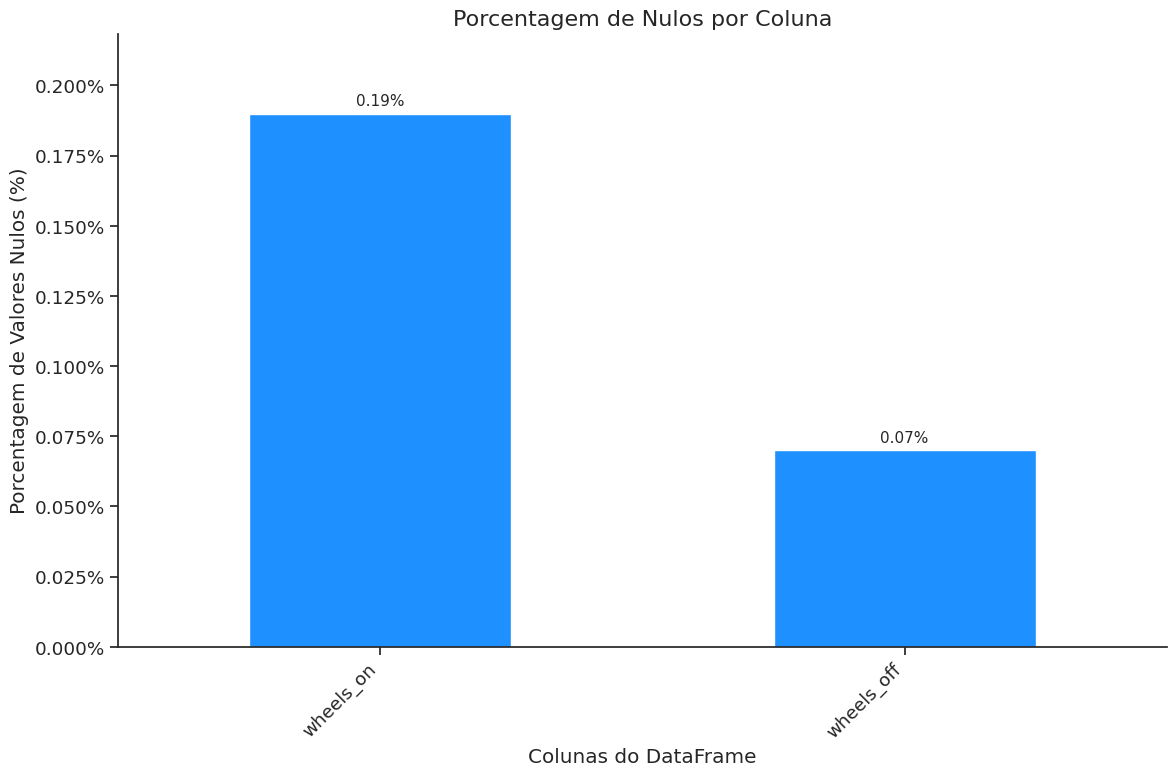

In [9]:
pct_nulos = null_summary[null_summary['%_missing'] > 0]['%_missing'].sort_values(ascending=False)

if not pct_nulos.empty:
    display(Markdown("**Foram encontrados valores nulos. Gerando gráfico...**"))
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plotagem
    pct_nulos.plot(kind='bar', color='dodgerblue', ax=ax)

    ax.set_title('Porcentagem de Nulos por Coluna', fontsize=16)
    ax.set_ylabel('Porcentagem de Valores Nulos (%)')
    ax.set_xlabel('Colunas do DataFrame')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points', fontsize=11)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Ajuste do limite Y para dar respiro ao gráfico
    plt.ylim(0, pct_nulos.max() * 1.15)
    plt.show()
else:
    display(Markdown("**Não foram encontrados valores nulos no conjunto de dados.**"))

#### Investigando valores ausentes nas colunas com final _DELAY

In [10]:
delay_cols = [c for c in silver_df.columns if c.endswith("_delay")]

delay_null_summary = silver_df[delay_cols].isna().sum().to_frame("n_missing")
delay_null_summary["pct_missing"] = (
    delay_null_summary["n_missing"] / len(silver_df) * 100
).round(2)

display(delay_null_summary)

,n_missing,pct_missing
departure_delay,0,0.0
arrival_delay,0,0.0
air_system_delay,0,0.0
security_delay,0,0.0
airline_delay,0,0.0
late_aircraft_delay,0,0.0
weather_delay,0,0.0


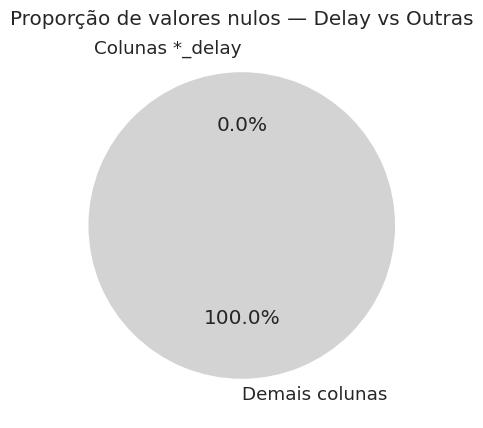

In [11]:
delay_missing = null_summary.loc[delay_cols, "n_missing"].sum()
other_missing = null_summary.loc[~null_summary.index.isin(delay_cols), "n_missing"].sum()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie([delay_missing, other_missing],
       labels=['Colunas *_delay', 'Demais colunas'],
       autopct='%1.1f%%',
       colors=['orange', 'lightgray'],
       startangle=90,
       explode=[0.05, 0])
ax.set_title('Proporção de valores nulos — Delay vs Outras')
plt.show()

Vamos visualizar a relação entre colunas que têm valores ausentes para identificar dependências estruturais.

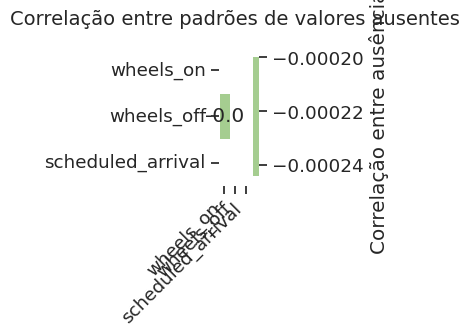

,col_1,col_2,corr


In [12]:
cols_with_missing = null_summary[null_summary["n_missing"] > 0].index.tolist()

if cols_with_missing:
    miss_matrix = silver_df[cols_with_missing].isna().astype(int)
    corr = miss_matrix.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(min(1.2*len(corr), 16), min(1.2*len(corr), 12)))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        cmap="crest",
        center=0,
        cbar_kws={'label': 'Correlação entre ausências'},
        fmt=".1f",
        linewidths=0.5
    )
    plt.title("Correlação entre padrões de valores ausentes", fontsize=14, pad=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    high_corr = (
        corr.where(~np.eye(len(corr), dtype=bool))
        .stack()
        .reset_index()
        .rename(columns={"level_0": "col_1", "level_1": "col_2", 0: "corr"})
        .query("corr > 0.85")
        .sort_values("corr", ascending=False)
    )
    display(high_corr.head(15))
else:
    print("Nenhuma coluna com valores ausentes.")


Vamos verificar se para voos que chegaram no horário ou adiantados, esses campos estão de fato vazios.

In [13]:
on_time_or_early = silver_df[silver_df['arrival_delay'] <= 0]

reason_columns = [
    'air_system_delay', 'security_delay', 'airline_delay', 
    'late_aircraft_delay', 'weather_delay'
]

non_null_counts = on_time_or_early[reason_columns].notnull().sum()
print("Contagem de valores preenchidos para voos pontuais:")
print(non_null_counts)

Contagem de valores preenchidos para voos pontuais:
air_system_delay       593110
security_delay         593110
airline_delay          593110
late_aircraft_delay    593110
weather_delay          593110
dtype: int64


#### Investigando valores ausentes nas colunas com final _TIME e relacionadas

In [14]:
time_cols = [c for c in silver_df.columns if c.endswith("_time")]

# Contagem de nulos
time_null_summary = silver_df[time_cols].isna().sum().to_frame("n_missing")
time_null_summary["pct_missing"] = (time_null_summary["n_missing"] / len(silver_df) * 100).round(2)
display(time_null_summary)

,n_missing,pct_missing
departure_time,0,0.0
arrival_time,0,0.0
air_time,0,0.0
elapsed_time,0,0.0
scheduled_time,0,0.0


In [15]:
silver_df['CALCULATED_ELAPSED_TIME'] = silver_df['taxi_out'] + silver_df['air_time'] + silver_df['taxi_in']
silver_df['TIME_DIFFERENCE'] = silver_df['elapsed_time'] - silver_df['CALCULATED_ELAPSED_TIME']

inconsistent_flights = silver_df[silver_df['TIME_DIFFERENCE'] != 0]
count_inconsistent = len(inconsistent_flights)
total_flights = len(silver_df)

print(f"Total de voos analisados: {total_flights}")
print(f"Número de voos com tempo inconsistente: {count_inconsistent}")

if count_inconsistent > 0:
    print(inconsistent_flights['TIME_DIFFERENCE'].describe())


Total de voos analisados: 1000000
Número de voos com tempo inconsistente: 0


### Cardinalidade e duplicatas

In [16]:
# Verificação de unicidade da PK
if silver_df['flight_id'].duplicated().any():
    print(f"🚨 ERRO DE PK: Existem {silver_df['flight_id'].duplicated().sum()} IDs duplicados.")

In [17]:
# Duplicatas
dup_complete = silver_df.duplicated().sum()
print(f"Duplicatas completas: {dup_complete:,}")

Duplicatas completas: 0


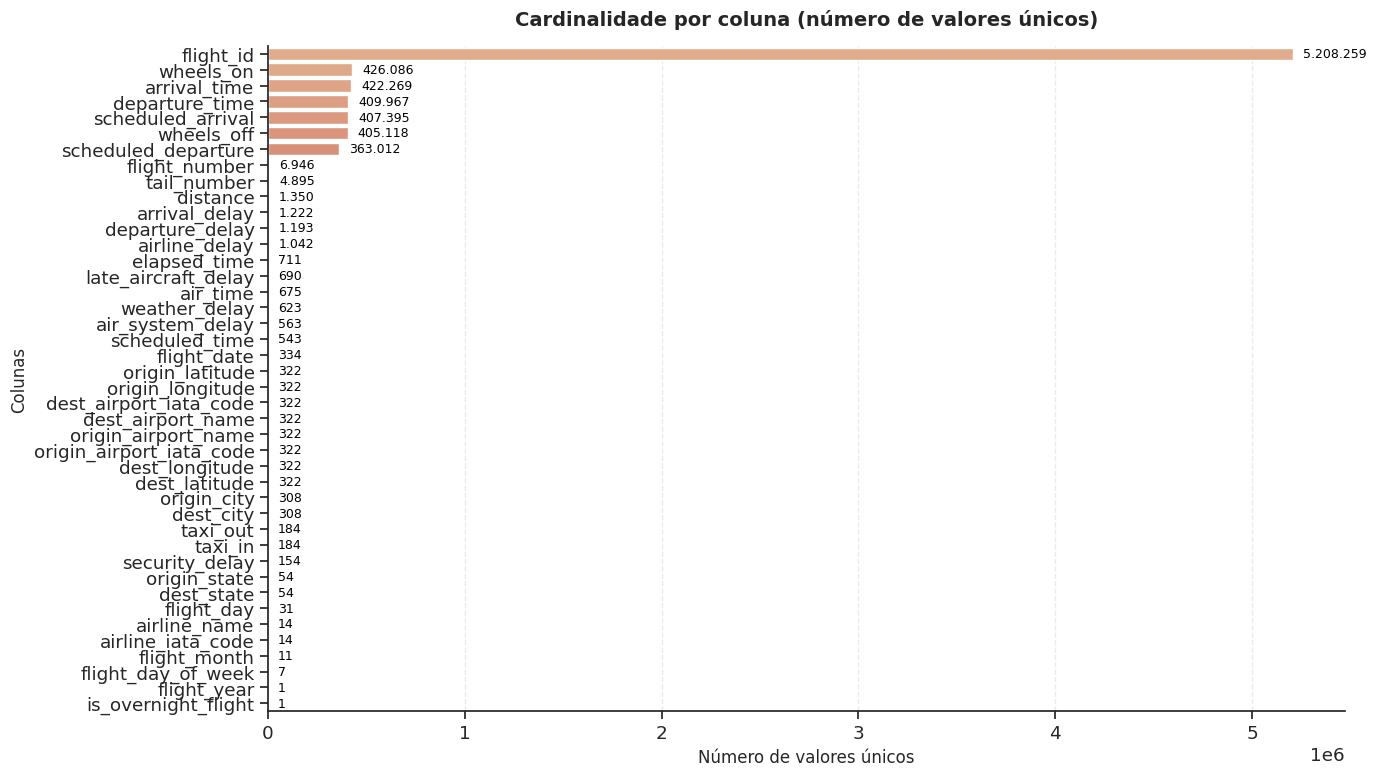

In [18]:
# Gráfico de duplicatas
# Gerando query para contar distintos
cols_query = []
colunas_locais = ["CALCULATED_ELAPSED_TIME", "TIME_DIFFERENCE"]

for col in silver_df.columns:
    # Só adiciona na query se a coluna NÃO for uma das locais
    if col not in colunas_locais:
        cols_query.append(f"COUNT(DISTINCT {col}) AS \"{col}\"")

query_card = f"SELECT {', '.join(cols_query)} FROM silver.silver_flights"
df_card_sql = get_db_data(query_card)

# Preparando para o gráfico
cardinality = df_card_sql.T.reset_index()
cardinality.columns = ["coluna", "n_valores_unicos"]
cardinality = cardinality.sort_values("n_valores_unicos", ascending=False)

# O código do gráfico (sns.barplot) abaixo desta célula pode permanecer IGUAL, 
# pois 'cardinality' agora é um dataframe pequeno, apenas com os resultados.
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=cardinality,
    x="n_valores_unicos",
    y="coluna",
    hue="coluna",
    palette="flare",
    orient="h",
    legend=False
)

for i, v in enumerate(cardinality["n_valores_unicos"]):
    ax.text(
        v + (0.01 * cardinality["n_valores_unicos"].max()),
        i,
        f"{v:,}".replace(",", "."),
        va="center",
        fontsize=9,
        color="black"
    )

ax.set_title("Cardinalidade por coluna (número de valores únicos)", fontsize=14, weight="bold", pad=15)
ax.set_xlabel("Número de valores únicos", fontsize=12)
ax.set_ylabel("Colunas", fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Verificação de tipos e inconsistências

In [19]:
core_columns = ['departure_delay', 'arrival_delay', 'air_time', 'tail_number', 'airline_name']
print("\nVerificando nulos em colunas essenciais:")
print(silver_df[core_columns].isnull().sum())



Verificando nulos em colunas essenciais:
departure_delay    0
arrival_delay      0
air_time           0
tail_number        0
airline_name       0
dtype: int64


In [20]:
reason_columns = ['airline_delay', 'weather_delay', 'late_aircraft_delay', 
                  'air_system_delay', 'security_delay']

print("Verificando nulos nas colunas de motivo de atraso:\n")
print(silver_df[reason_columns].isnull().sum())



Verificando nulos nas colunas de motivo de atraso:

airline_delay          0
weather_delay          0
late_aircraft_delay    0
air_system_delay       0
security_delay         0
dtype: int64


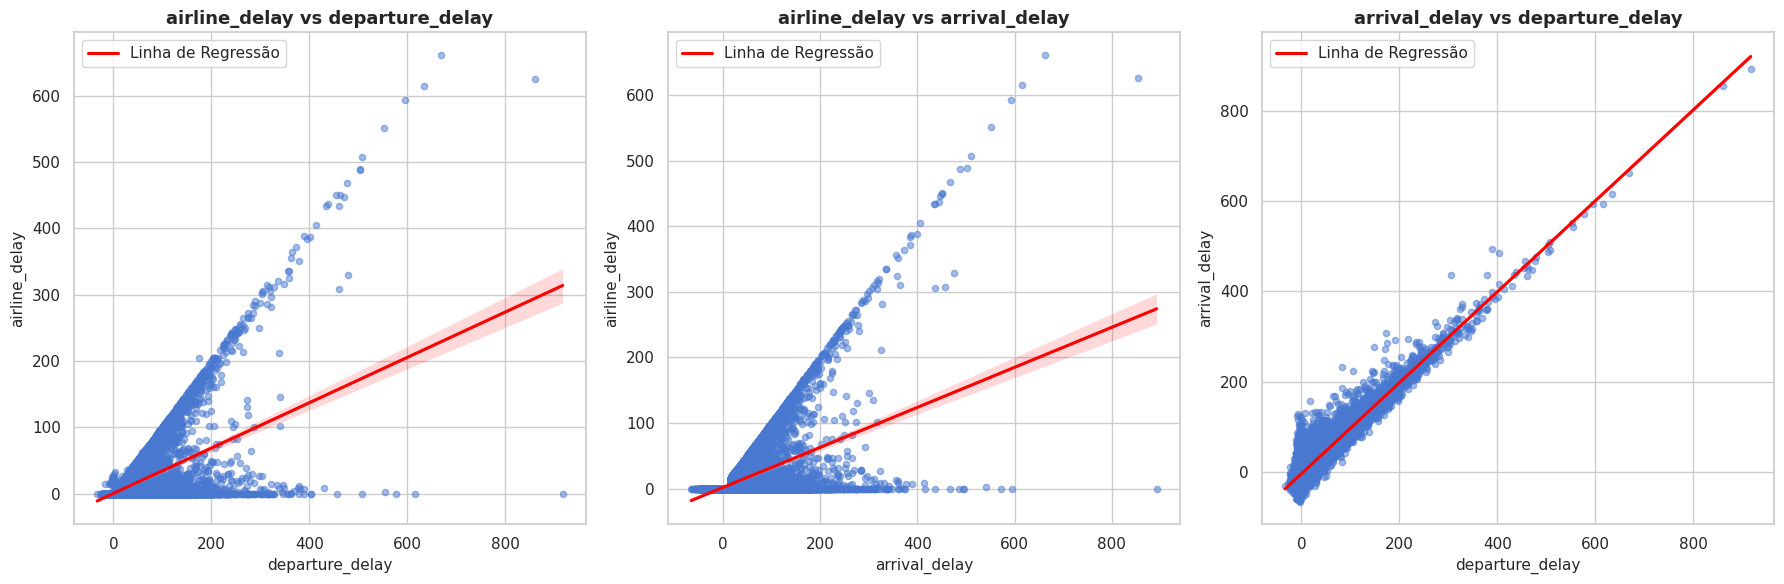

In [23]:
cols_delay = [
    ("departure_delay", "airline_delay"),
    ("arrival_delay", "airline_delay"),
    ("departure_delay", "arrival_delay")
]

# Estilo visual
sns.set(style="whitegrid", palette="muted")

n_samples = min(50000, len(silver_df))
sample_df = silver_df.sample(n=n_samples, random_state=42)

# Tamanho do grid
fig, axes = plt.subplots(1, len(cols_delay), figsize=(18, 6))

for i, (x_col, y_col) in enumerate(cols_delay):
    ax = axes[i]
    sns.regplot(
        data=sample_df,
        x=x_col,
        y=y_col,
        ax=ax,
        scatter_kws={'alpha': 0.5, 's': 20},
        line_kws={'color': 'red', 'label': 'Linha de Regressão'}
    )
    ax.set_title(f'{y_col} vs {x_col}', fontsize=13, fontweight='bold')
    ax.set_xlabel(x_col, fontsize=11)
    ax.set_ylabel(y_col, fontsize=11)
    ax.legend()

plt.tight_layout()
plt.show()


In [22]:
cols = ['scheduled_departure', 'departure_time', 'scheduled_arrival', 'arrival_time', 'wheels_off', 'wheels_on']

display(silver_df.head()[cols])

,scheduled_departure,departure_time,scheduled_arrival,arrival_time,wheels_off,wheels_on
0,2015-06-19 16:44:00,2015-06-19 16:42:00,2015-06-19 18:23:00,2015-06-19 18:07:00,2015-06-19 16:50:00,2015-06-19 17:59:00
1,2015-06-19 07:45:00,2015-06-19 07:37:00,2015-06-19 13:15:00,2015-06-19 13:02:00,2015-06-19 07:51:00,2015-06-19 12:51:00
2,2015-06-19 07:10:00,2015-06-19 07:04:00,2015-06-19 08:56:00,2015-06-19 08:52:00,2015-06-19 07:27:00,2015-06-19 08:43:00
3,2015-06-19 23:50:00,2015-06-19 00:26:00,2015-06-19 07:23:00,2015-06-19 07:37:00,2015-06-19 00:41:00,2015-06-19 07:29:00
4,2015-06-19 20:12:00,2015-06-19 20:22:00,2015-06-19 20:30:00,2015-06-19 20:32:00,2015-06-19 20:37:00,2015-06-19 20:27:00
